In [1]:
!pip install jiwer
!pip install Levenshtein
!pip install spacy
!python -m spacy download xx_ent_wiki_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 89.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import spacy
import jiwer
import Levenshtein
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import sys
import nltk
import pandas as pd

In [3]:
# !python -m spacy download xx_ent_wiki_sm

In [4]:
# Load the Hindi tokenizer (spaCy)
nlp = spacy.blank("hi")

In [5]:
# Load the spaCy Hindi model
# nlp = spacy.load("xx_ent_wiki_lg")

In [6]:
# nltk.download('punkt_tab')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Function to calculate WER (Word Error Rate)
def calculate_wer(reference, hypothesis):
    return jiwer.wer(reference, hypothesis)

# Function to calculate CER (Character Error Rate)
def calculate_cer(reference, hypothesis):
    return Levenshtein.distance(reference, hypothesis) / max(len(reference), 1)


def compute_bleu_word(reference, hypothesis):
    """
    Compute BLEU score for a single sentence with Hindi tokenization using spaCy.
    """
    reference_tokens = [token.text for token in nlp(reference)]
    hypothesis_tokens = [token.text for token in nlp(hypothesis)]

    # Use smoothing to handle cases with no matches
    smoothing = SmoothingFunction().method1
    return sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothing)

def calculate_bleu_char(reference, hypothesis):
    reference_tokens = [list(reference)]  # Reference is tokenized as a list of characters/words
    hypothesis_tokens = list(hypothesis)  # Hypothesis is tokenized similarly
    smoothing_function = SmoothingFunction().method1  # Apply smoothing
    return sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothing_function)

# def compute_bleu_word(reference, hypothesis):
#     """
#     Compute BLEU score for a single sentence.
#     """
#     reference_tokens = nltk.word_tokenize(reference)
#     hypothesis_tokens = nltk.word_tokenize(hypothesis)
#     # Use smoothing to handle cases with no matches
#     smoothing = SmoothingFunction().method1
#     return sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothing)

# Function to evaluate the model using CSV input

def compute_bleu_1gram(reference, hypothesis):
    """
    Compute BLEU score for a single sentence with 1-gram (unigram) matching, using Hindi tokenization with spaCy.
    """
    # Tokenize the reference and hypothesis using spaCy
    reference_tokens = [token.text for token in nlp(reference)]
    hypothesis_tokens = [token.text for token in nlp(hypothesis)]

    # Set the n-gram order to 1 for unigram BLEU
    ngram_order = 1

    # Use smoothing to handle cases with no matches
    smoothing = SmoothingFunction().method1

    # Compute BLEU score (using only 1-gram)
    return sentence_bleu([reference_tokens], hypothesis_tokens, weights=[1.0] * ngram_order, smoothing_function=smoothing)

def compute_bleu_ngrams(reference, hypothesis):
    """
    Compute BLEU scores for 1-gram, 2-gram, 3-gram, and 4-gram matching using Hindi tokenization with spaCy.
    """
    # Tokenize the reference and hypothesis using spaCy
    reference_tokens = [token.text for token in nlp(reference)]
    hypothesis_tokens = [token.text for token in nlp(hypothesis)]

    # Define the n-gram orders to evaluate
    ngram_orders = [1, 2, 3, 4]

    # Use smoothing to handle cases with no matches
    smoothing = SmoothingFunction().method1

    bleu_scores = {}

    # Compute BLEU scores for each n-gram order
    for ngram_order in ngram_orders:
        # BLEU weights for the current n-gram order
        weights = [1.0 / ngram_order] * ngram_order

        # Compute BLEU score for the current n-gram order
        bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens, weights=weights, smoothing_function=smoothing)

        # Store the BLEU score
        bleu_scores[f'BLEU-{ngram_order}'] = bleu_score

    return bleu_scores

def evaluate_model_from_csv(csv_file):
    # Load the CSV into a pandas DataFrame
    df = pd.read_csv(csv_file, encoding='utf-8')

    # Extract the ground truth and predicted columns
    references = df.iloc[:, 1].tolist()  # Ground truth (first column)
    hypotheses = df.iloc[:, 2].tolist()  # Predicted (second column)

    wer_scores, cer_scores, bleu_char, bleu_word = [], [], [], []

    for reference, hypothesis in zip(references, hypotheses):
        reference, hypothesis = reference.strip(), hypothesis.strip()
        wer_scores.append(calculate_wer(reference, hypothesis))
        cer_scores.append(calculate_cer(reference, hypothesis))
        bleu_char.append(calculate_bleu_char(reference, hypothesis))
        bleu_word.append(compute_bleu_word(reference, hypothesis))


    # Calculate the averages of each metric
    avg_wer = sum(wer_scores) / len(wer_scores)
    avg_cer = sum(cer_scores) / len(cer_scores)
    avg_bleu_char = sum(bleu_char) / len(bleu_char)
    avg_bleu_word = sum(bleu_word) / len(bleu_word)

    # Print out the average scores
    print(f"Word Error Rate (WER): {avg_wer:.4f}")
    print(f"Character Error Rate (CER): {avg_cer:.4f}")
    print(f"BLEU-char Score: {avg_bleu_char:.4f}")
    print(f"BLEU-word Score: {avg_bleu_word:.4f}")


In [9]:
%cd /content/drive/MyDrive/PhD/transliteration/llama/data/result/

/content/drive/MyDrive/PhD/transliteration/llama/data/result


In [ ]:
# Example usage
csv_file = 'fine_tuned_llama/Hindi_Test_Set_1_output_trained_llama.csv'
evaluate_model_from_csv(csv_file)

Word Error Rate (WER): 0.1892
Character Error Rate (CER): 0.0684
BLEU-char Score: 0.8866
BLEU-word Score: 0.6434


In [ ]:
# Example usage
csv_file = 'fine_tuned_llama/Hindi_Test_Set_2_output_trained_llama.csv'
evaluate_model_from_csv(csv_file)

Word Error Rate (WER): 0.2640
Character Error Rate (CER): 0.1183
BLEU-char Score: 0.8176
BLEU-word Score: 0.5288


In [ ]:
# Example usage
csv_file = 'pretrained_llama/Hindi_Test_Set_1_prdicted.csv'
evaluate_model_from_csv(csv_file)

Word Error Rate (WER): 0.2154
Character Error Rate (CER): 0.0881
BLEU-char Score: 0.8675
BLEU-word Score: 0.6159


In [ ]:
# Example usage
csv_file = 'pretrained_llama/Hindi_Test_Set_2_prdicted.csv'
evaluate_model_from_csv(csv_file)

Word Error Rate (WER): 0.2851
Character Error Rate (CER): 0.1339
BLEU-char Score: 0.8029
BLEU-word Score: 0.4879


In [ ]:
# Example usage
csv_file = 'indicxlit/evaluation_results_set_1.csv'
evaluate_model_from_csv(csv_file)

Word Error Rate (WER): 0.4552
Character Error Rate (CER): 0.1785
BLEU-char Score: 0.7319
BLEU-word Score: 0.2505


In [ ]:
# Example usage
csv_file = 'indicxlit/evaluation_results_set_2.csv'
evaluate_model_from_csv(csv_file)

Word Error Rate (WER): 0.5320
Character Error Rate (CER): 0.2313
BLEU-char Score: 0.6567
BLEU-word Score: 0.1689


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to apply moving average smoothing
def moving_average(data, window_size=3):
    """
    Apply simple moving average smoothing.
    Arguments:
    - data: List of data points.
    - window_size: Size of the moving window (default is 3).

    Returns:
    - smoothed_data: List of smoothed data points.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


def plot_blue_word(csv_file):
    # Load the CSV into a pandas DataFrame
    df = pd.read_csv(csv_file, encoding='utf-8')

    # Extract the ground truth and predicted columns
    references = df.iloc[:, 1].tolist()  # Ground truth (first column)
    hypotheses = df.iloc[:, 2].tolist()  # Predicted (second column)

    bleu_word = []
    word_lengths = []  # To store the word length (in tokens)

    for reference, hypothesis in zip(references, hypotheses):
        reference, hypothesis = reference.strip(), hypothesis.strip()

        # Calculate BLEU score (modify this line if using 1-gram BLEU score)
        bleu_word.append(calculate_bleu_char(reference, hypothesis))  # Change to compute_bleu_word if needed

        # Calculate word length (number of tokens)
        ref_tokens = [token for token in reference.split()]  # Tokenize using spaCy
        word_lengths.append(len(ref_tokens))  # We only need reference length for x-axis

    # Group BLEU scores by the reference word length (number of tokens)
    bleu_by_length = defaultdict(list)
    for length, bleu in zip(word_lengths, bleu_word):
        bleu_by_length[length].append(bleu)

    # Calculate average, max, and min BLEU scores for each word length
    avg_bleu_by_length = {length: sum(scores)/len(scores) for length, scores in bleu_by_length.items()}
    max_bleu_by_length = {length: max(scores) for length, scores in bleu_by_length.items()}
    min_bleu_by_length = {length: min(scores) for length, scores in bleu_by_length.items()}

    # Sort by word length for proper plotting
    sorted_lengths = sorted(avg_bleu_by_length.keys())

    avg_bleu_scores = [avg_bleu_by_length[length] for length in sorted_lengths]
    max_bleu_scores = [max_bleu_by_length[length] for length in sorted_lengths]
    min_bleu_scores = [min_bleu_by_length[length] for length in sorted_lengths]

    # Apply smoothing (moving average)
    smoothed_avg_bleu = moving_average(avg_bleu_scores, window_size=3)
    smoothed_max_bleu = moving_average(max_bleu_scores, window_size=3)
    smoothed_min_bleu = moving_average(min_bleu_scores, window_size=3)

    # Calculate variance
    bleu_variance_by_length = {length: np.var(scores) for length, scores in bleu_by_length.items()}
    bleu_variance = [bleu_variance_by_length[length] for length in sorted_lengths]

    # Apply smoothing to variance (optional)
    smoothed_variance = moving_average(bleu_variance, window_size=3)

    # Plotting: Line graph for token word length vs average, max, and min BLEU score
    fig, ax1 = plt.subplots(figsize=(5, 4))

    # Plot smoothed BLEU score
    ax1.plot(sorted_lengths[:len(smoothed_avg_bleu)], smoothed_avg_bleu, color='blue', label='BLEU Score')
    ax1.set_xlabel('Text Length (Number of Words)',fontsize=12)
    ax1.set_ylabel('Average BLEU Score (Character-based)',fontsize=12, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    # Set the y-axis range for the left axis (average BLEU score)
    ax1.set_ylim(0.5, 0.9)

    # Create a second y-axis for variance
    ax2 = ax1.twinx()
    ax2.plot(sorted_lengths[:len(smoothed_variance)], smoothed_variance, color='red', label='Variance', linestyle='--')
    ax2.set_ylabel('Variance of BLEU Score', color='red',fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # Adding labels and title
    ax1.legend(loc='center right', bbox_to_anchor=(1, 0.6))  # Top-center right legend for avg BLEU
    ax2.legend(loc='center right', bbox_to_anchor=(1, 0.4))  # Bottom-center right legend for variance
    # Show the plot
    # plt.grid(True)
    plt.tight_layout()
    # Save the plot to a PDF file
    plt.savefig('blue_score_set_2.pdf', format='pdf')

    # Show plot
    # plt.title('Word Length vs BLEU Score and Variance (Smoothed)')
    plt.show()

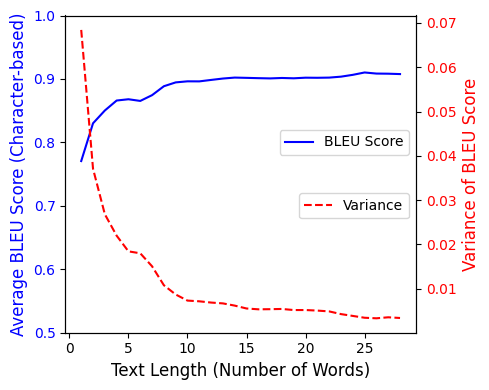

In [62]:
# Example usage
csv_file = 'fine_tuned_llama/Hindi_Test_Set_1_output_trained_llama.csv'
plot_blue_word(csv_file)

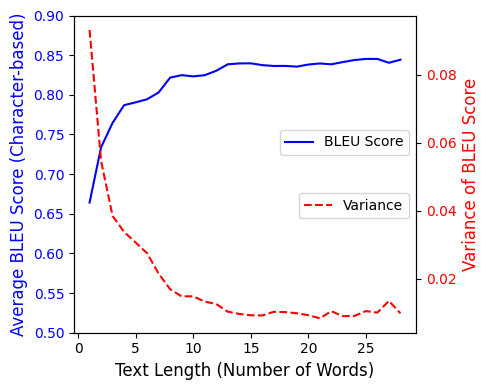

In [64]:
# Example usage
csv_file = 'fine_tuned_llama/Hindi_Test_Set_2_output_trained_llama.csv'
plot_blue_word(csv_file)

In [ ]:
def plot_blue_word(csv_file):
    # Load the CSV into a pandas DataFrame
    df = pd.read_csv(csv_file, encoding='utf-8')

    # Extract the ground truth and predicted columns
    references = df.iloc[:, 1].tolist()  # Ground truth (first column)
    hypotheses = df.iloc[:, 2].tolist()  # Predicted (second column)

    bleu_word = []
    word_lengths = []  # To store the word length (in tokens)

    for reference, hypothesis in zip(references, hypotheses):
        reference, hypothesis = reference.strip(), hypothesis.strip()

        # Calculate BLEU score (modify this line if using 1-gram BLEU score)
        bleu_word.append(calculate_bleu_char(reference, hypothesis))  # Change to compute_bleu_word if needed

        # Calculate word length (number of tokens)
        ref_tokens = [token.text for token in nlp(reference)]  # Tokenize using spaCy
        word_lengths.append(len(ref_tokens))  # We only need reference length for x-axis

    # Group BLEU scores by the reference word length (number of tokens)
    bleu_by_length = defaultdict(list)
    for length, bleu in zip(word_lengths, bleu_word):
        bleu_by_length[length].append(bleu)

    # Calculate variance of BLEU scores for each word length
    variance_bleu_by_length = {length: np.var(scores) for length, scores in bleu_by_length.items()}

    # Sort by word length for proper plotting
    sorted_lengths = sorted(variance_bleu_by_length.keys())

    variance_bleu_scores = [variance_bleu_by_length[length] for length in sorted_lengths]

    # Apply smoothing (moving average) to the variance values
    smoothed_variance_bleu = moving_average(variance_bleu_scores, window_size=6)

    # Plotting: Line graph for token word length vs variance of BLEU score
    plt.figure(figsize=(6, 6))

    # Plot smoothed variance values
    plt.plot(sorted_lengths[:len(smoothed_variance_bleu)], smoothed_variance_bleu, color='orange', label='Variance of BLEU Score')

    # Adding labels and title
    plt.title('Word Length vs Variance of BLEU Score (Word-based)')
    plt.xlabel('Reference Word Length (Number of Tokens)')
    plt.ylabel('Variance of BLEU Score (Word-based)')
    plt.legend()

    # Show plot
    plt.show()

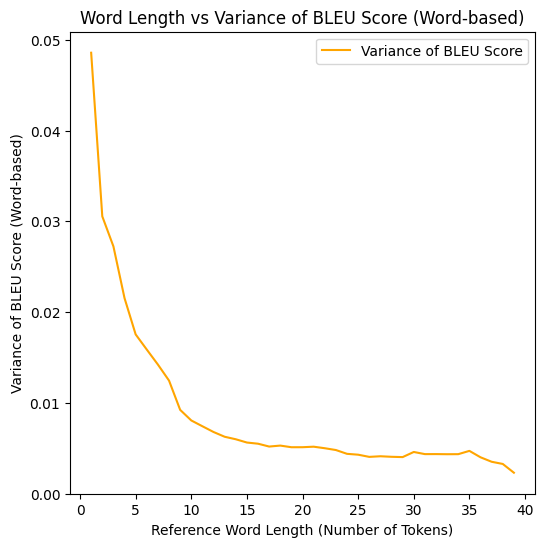

In [ ]:
# Example usage
csv_file = 'fine_tuned_llama/Hindi_Test_Set_1_output_trained_llama.csv'
plot_blue_word(csv_file)